In [1]:
# conda create -n tensorflow_gpuenv tensorflow-gpu
# conda activate tensorflow_gpuenv
# ! conda install -c anaconda git 
# !pip install -q git+https://github.com/hyperopt/hyperopt.git
# !pip install seaborn
# !pip install lightgbm scikit-learn

In [14]:
# !pip install hyperopt
# !pip install sklearn
# %tensorflow_version 2.x
from hyperopt import tpe as tpe
import tensorflow as tf
import sklearn.metrics as mets
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import least_squares, differential_evolution
from hyperopt import fmin, Trials, hp, STATUS_OK
from hyperopt.pyll.stochastic import sample
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from functools import reduce
from functools import partial
import pandas as pd
from scipy import stats
from tensorflow import keras
from tensorflow.keras import layers
i = complex(0,1)
np.random.seed(42)
sns.set(style="whitegrid")

In [3]:
print("tensor flow version: ", tf.__version__)
print("Is there a GPU available: "),
print(tf.config.experimental.list_physical_devices("GPU"))
tf.config.list_physical_devices('GPU')

tensor flow version:  2.1.0
Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def drange(x, y, jump):
    '''
    simple float numbers-range generator
    '''
    return np.arange(x,y,jump)

def bsfftcf2(u,p,r,t,sig,q):
    '''
    Characteristic function for the BS model
    '''
    y=np.exp(i*u*(np.log(p)+(r-q-(1/2)*sig**2)*t))*np.exp(-(1/2)*sig**2*u**2*t)
    return y

def hestonfftcf(th,u,ka,S0,rho,r,t,sig,q,eta):
    '''
    Characteristic function for the Heston model
    '''

    # Initial calculations
    d = ((rho*th*u*i - ka)**2 - th**2*(-i*u - u**2))**(1/2)
    g = (ka - rho*th*u*i - d) / (ka - rho*th*u*i + d)

    # Final answer
    y = np.exp(i*u*(np.log(S0) + (r-q)*t)) \
    *np.exp(eta*ka*th**-2*((ka - rho*th*u*i - d)*t - 2*np.log((1 - g*np.exp(-d*t))/(1-g)))) \
    *np.exp(sig**2*th**-2*(ka - rho*th*i*u - d)*(1 - np.exp(-d*t))/(1 - g*np.exp(-d*t)))

    return y

def batesfftcf(th,u,ka,S0,rho,r,t,sig,q,eta,lmb,nu,jet):
    ''' 
    Characteristic function for the Bates model
    '''
    # Initial calculations
    d = ((rho*th*u*i - ka)**2 - th**2*(-i*u - u**2))**(1/2)
    g = (ka - rho*th*u*i - d) / (ka - rho*th*u*i + d)

    # Final answer
    y = np.exp(i*u*(np.log(S0) + (r-q)*t)) \
      *np.exp(eta*ka*th**-2*((ka - rho*th*u*i - d)*t - 2*np.log((1 - g*np.exp(-d*t))/(1-g)))) \
      *np.exp(sig**2*th**-2*(ka - rho*th*i*u - d)*(1 - np.exp(-d*t))/(1 - g*np.exp(-d*t))) \
      *np.exp(-lmb*nu*i*u*t+lmb*t*((1+nu)**(i*u)*np.exp(jet**2*(i*u/2)*(i*u-1))-1))
    return y

def fft_price(S0, r, q, K, T, model_name,verbose = False,callput='c', diag = True, **kwargs):
    # Carr-Madan reference values
    t0 = time()
    N = 4096; i = complex(0,1); alpha = 1.5; etacm = 0.25
    
    # Validate data types
    if hasattr(T, '__iter__'):
        T = np.array(T).reshape(-1,1)
    else:
        T = np.array([T]).reshape(-1,1)
    if hasattr(r, '__iter__'):
        r = np.array(r).reshape(-1,1)
    else:
        r = np.array([r]).reshape(-1,1)
    if hasattr(S0, '__iter__'):
        S0 = np.array(S0).reshape(-1,1)
        assert len(T) == len(S0), "T and S0 must have the same length"
    if hasattr(K, '__iter__'):
        K = np.array(K)
    else:
        K = [K]
    if hasattr(q, '__iter__'):
        q = np.array(q).reshape(-1,1)
        assert len(T) == len(q), "T and q must have the same length"
    assert len(T) == len(r), "T and r must have the same length"
    
    # General calculations
    lmbd = 2*np.pi/N/etacm
    b = lmbd*N/2
    kcalc = np.array(drange(-b,b-(lmbd/2),lmbd)).reshape(1,-1)
    KK = np.exp(kcalc)
    v = np.array(drange(0,(N)*etacm,etacm)).reshape(1,-1)
    sw = (3 + np.power(-1,np.array(range(1,N+1))))
    sw[0] = 1
    sw = (sw/3).reshape(1,-1)

    # Working with the denominator
    partialnum = np.exp(-r*T)
    partialden = alpha**2+alpha-v**2+i*(2*alpha+1)*v

    partialop = partialnum/partialden

    u = v-(alpha+1)*i
    #u[u.real==0] = u[u.real==0]+.01e-9 
    

    # Model Selection
    if model_name == 'BS':
        op = partialop * bsfftcf2(u = u, p = S0, r = r, t = T, q = q, **kwargs)
    elif model_name == 'Heston':
        op = partialop * hestonfftcf(u = u, S0 = S0, r = r, t = T, q = q, **kwargs)
    elif model_name == 'Bates':
        op = partialop * batesfftcf(u = u, S0 = S0, r = r, t = T, q = q, **kwargs)
    else:
        raise ValueError('Please insert a valid model: "BS", "Heston" or "Bates"')

    A = op * np.exp(i * v * b) * etacm * sw

    if verbose:
        t1 = time()
        print("time taken in algebraic operations: ",t1-t0)
        
    Z = np.array(list(map(np.fft.fft,A))).real
    
    if verbose:
        t2 = time()
        print("time taken in FFT: ",t2-t1)

    CallPricesBS = np.exp(-alpha * kcalc) / np.pi * Z

    if diag:
        CallPricesL = list(map(lambda x: interp1d(KK.reshape(-1),x[0], kind='cubic')(x[1]),
                           zip(CallPricesBS,K)))
        
    else:
        CallPricesL = list(map(lambda x: interp1d(KK.reshape(-1),x, kind='cubic')(K),
                           CallPricesBS))
    if verbose:        
        t3 = time()
        print("time taken in interpolation",t3-t2)
    
    price = np.array(CallPricesL)
    if sum(~np.isfinite(price.reshape(-1,)))>0:
        price[~np.isfinite(price)] = 9e30
    if callput == 'p':
        if diag:
            price +=  K*(np.exp(-r*T)).reshape(-1,)-(S0*np.exp(-q*T)).reshape(-1,)
        else:
            price +=  K*(np.exp(-(r*T)))-(S0*np.exp(-q*T))

    return price


# Function to optimize for the models Heston
def residual_heston(params,K,r,T,S0,q,Y,callput,diag):
    '''
    Residual function for the Heston parameter optimization.
    '''
    sig, th, ka, rho, eta = params

    return fft_price(S0=S0,r=r, q=q, K=K, T=T, model_name='Heston',
                         sig = sig,th=th,ka=ka,rho=rho,eta=eta,
                         callput=callput,diag=diag).reshape(-1,)-Y

def scipy_heston(x0,K,r,T,S0,q,Y,callput,diag):
    '''
    Wrapper for gradient-based least squares optimization on the Heston eq.
    '''
    bounds = np.array([[.2,0.01,0,-.9,0.01],[.8,.8,3,0,.5]])
    t0 = time()
    res = differential_evolution(func = residual_heston,
                                 args=(K,r,T,S0,q,Y,callput,diag), 
                                 bounds=[[0.2, 0.8], [0.01, 0.8], [0.0, 3.0], [-0.9, 0.0], [0.01, 0.5]])
#                                  workers=-1)

    t1 = time()
    print("Scipy time: ", t1-t0)
    print("Success", res.success,res.message)
    return res

def objective_heston(params,K,r,T,S0,q,Y,callput,diag):
    '''
    Residual function for the Heston parameter optimization.
    '''
    Y_pred = fft_price(S0=S0,r=r, q=q, K=K, T=T, model_name='Heston',
                       callput=callput,diag=diag,**params).reshape(-1,)
    if sum(~np.isfinite(Y_pred.reshape(-1,)))>0:
        Y_pred[~np.isfinite(Y_pred)] = 9e30
    err = mets.mean_squared_error(Y,Y_pred)
    return {'loss': err, 'parameters': params, 'status': STATUS_OK, 'preds':Y_pred}

## Search space for hyperopt bayesian optimization 
space_heston = {'sig': hp.uniform('sig', .2, .8),
               'th': hp.uniform('th', .01, .8),
               'ka': hp.uniform('ka', 0, 3),
               'rho': hp.uniform('rho', -.9, 0),
               'eta': hp.uniform('eta', 0.01, .5),}


# Function to optimize for the models Bates
def residual_bates(params,K,r,T,S0,q,Y,callput,diag):
    '''
    Residual function for the Bates parameter optimization.
    '''
    sig, th, ka, rho, eta, lmb, nu, jet = params
    return Y - fft_price(S0=S0, r=r, q=q, K=K, T=T, model_name='Bates', 
                         sig = sig,th=th,ka=ka,rho=rho,eta=eta,lmb=lmb,
                         nu=nu,jet=jet,callput=callput,diag=diag).reshape(-1,)

def scipy_bates(x0,K,r,T,S0,q,Y,callput,diag,mevals=500):
    '''
    Wrapper for gradient-based least squares optimization on the Heston eq.
    '''
    bounds = ([.2,0.01,0,-.9,0.01,0,-1,0],[.8,.8,3,0,.5,1,1,1])
    t0 = time()
    res = least_squares(residual_bates,x0,bounds=bounds,args=(K,r,T,S0,q,Y,callput,diag),
                    method="dogbox",max_nfev=mevals,jac="2-point",loss="soft_l1", tr_solver="exact")
    t1 = time()
    print("Scipy time: ", t1-t0)
    print("Success", res.success,res.message)
    return res

def objective_bates(params,K,r,T,S0,q,Y,callput,diag):
    '''
    Residual function for the Heston parameter optimization.
    '''

    Y_pred = fft_price(S0=S0, r=r, q=q, K=K, T=T, model_name='Bates',
                       callput=callput, diag=diag, **params).reshape(-1,)
    if sum(~np.isfinite(Y_pred.reshape(-1,)))>0:
        Y_pred[~np.isfinite(Y_pred)] = 9e30
    err = np.sqrt(mets.mean_squared_error(Y,Y_pred))
    return {'loss': err, 'parameters': params, 'status': STATUS_OK, 'preds':Y_pred}


space_bates = {'sig': hp.uniform('sig', .2, .8),
               'th': hp.uniform('th', .01, .8),
               'ka': hp.uniform('ka', 0, 3),
               'rho': hp.uniform('rho', -.9, 0),
               'eta': hp.uniform('eta', 0.01, .5),
               'lmb': hp.uniform('lmb', 0, 1),
               'nu': hp.uniform('nu', -1, 1),
               'jet': hp.uniform('jet', 0, 1)}


def hyperscipy(K,r,T,S0,q,Y,model='heston', callput = 'c', diag=True):
    '''
    Perform hypeopt bayesian optimization and uses the resulting parameters as
    starting point for the scipy least square optimization.
    '''
    tt0 = time()
    trials = Trials()

    if model == 'heston':
#         Adjusment to allow hyperopt to receive additional parameters
        fmin_objective_heston = partial(objective_heston, K=K, r=r, T=T, 
                                        S0=S0, q=q, Y=Y, callput=callput,
                                        diag=diag)
        # hyperopt optimization
        best = fmin(fmin_objective_heston, space_heston, algo=tpe.suggest, 
                    trials=trials, max_evals=50)
        x0 = (best['sig'], best['th'], best['ka'], best['rho'], best['eta'])
        x0 = (.5,.5,.5,-.5,.5)
        params = scipy_heston(x0,K,r,T,S0,q,Y,callput,diag)
    
    if model == 'bates':
        # Adjusment to allow hyperopt to receive additional parameters
        fmin_objective_bates = partial(objective_bates, K=K, r=r, T=T, 
                                        S0=S0, q=q, Y=Y,callput=callput,diag=diag)
        # hyperopt optimization
        best = fmin(fmin_objective_bates, space_bates, algo=tpe.suggest, 
                    trials=trials, max_evals=75)

        x0 = (best['sig'], best['th'], best['ka'], best['rho'], best['eta'], best['lmb'], best['nu'], best['jet'])
        
        params = scipy_bates(x0,K,r,T,S0,q,Y,callput,diag,100)

    print("Total time:",time()-tt0)
    print("Total time in minutes:",(time()-tt0)/60.)
    print("\nFinal Cost", params.cost)
    return params.x

# Calibrating Parameters using theoretical data for Heston

In [5]:
# K_h = drange(80,134,.01)[:40]
# r_h = drange(.001,.5,.005)[:40]
# T_h = drange(.2,5,.1)[:40]
# S0_h,q_h = 135, .001

# Y_h = fft_price(S0=S0_h, r=r_h, q=q_h, K=K_h, T=T_h, model_name='Heston', callput='c',diag=True,
#           sig = 0.5,th=.1,ka=.1,rho=-0.75,eta=.04,verbose=True).reshape(-1,)

# hyperscipy(K_h,r_h,T_h,S0_h,q_h,Y_h,callput='p',diag=True)

# Calibration for the Bates model

In [6]:
# K_b = drange(80,134,.01)[:48]
# r_b = drange(.001,.5,.005)[:48]
# T_b = drange(.2,5,.1)
# S0_b,q_b = 135, .001

# Y = fft_price(S0=S0_b, r=r_b, q=q_b, K=K_b, T=T_b, model_name='Bates', 
#               sig = 0.2,th=.1,ka=.1,rho=-0.75,eta=.04,lmb=.1,
#               nu=.5,jet=.3,diag=True).reshape(-1,)


# hyperscipy(K_b,r_b,T_b,S0_b,q_b,Y,model='bates',diag=True)

# Testing on actual data

In [7]:
dividendsdf = pd.read_csv("../data/dividends.csv",index_col=0)
interestdf = pd.read_csv("../data/interest_rates.csv")
optionsdf = pd.read_csv("../data/options.csv")
spotdf = pd.read_csv("../data/spot.csv")
optionsdf.head(3)

underlying                 symbol        date  expiration  strike call_put  \
0          A  A     190517C00042500  2019-05-14  2019-05-17    42.5        C   
1          A  A     190517P00042500  2019-05-14  2019-05-17    42.5        P   
2          A  A     190517C00045000  2019-05-14  2019-05-17    45.0        C   

  style    bid    ask  mean_price  settlement  volume  open_interest  \
0     A  32.95  34.75       33.85         0.0     0.0            0.0   
1     A   0.00   0.18        0.00         0.0     0.0            1.0   
2     A  30.50  32.40       31.45         0.0     0.0            0.0   

    eu_price  us_price  iv_exchange        iv  id  
0  33.811133     33.85       0.6987  0.003413   1  
1   0.000000      0.00       0.7780  0.001000   2  
2  31.311628     31.45       0.6987  0.003130   3

Text(0.5, 1.0, 'Call Options')

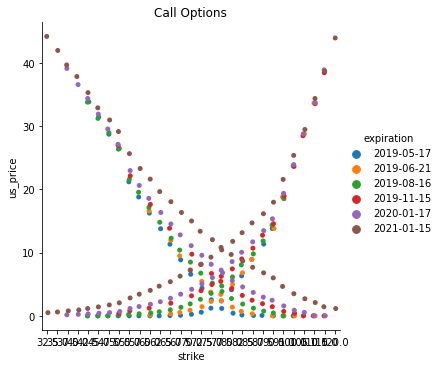

In [8]:
sns.catplot(x="strike", y="us_price", hue="expiration", data=optionsdf,legend= 'full',palette=sns.color_palette())
plt.title('Call Options')
# sns.catplot(x="strike", y="eu_price", hue="expiration", data=optionsdf[optionsdf.call_put == 'P'],legend= 'full',palette=sns.color_palette())
# plt.title('Put Options')

In [21]:
# Data formating
# df = optionsdf[optionsdf.call_put == 'C'][['strike','eu_price','underlying']]
optionsdf = optionsdf[optionsdf.open_interest != 0]
df = optionsdf[['strike','eu_price','underlying','call_put']]
df['time_maturity'] = (pd.to_datetime(optionsdf.expiration) - pd.to_datetime(optionsdf.date)).astype('timedelta64[D]')/30/12
print(len(df))
print(df.head())
# Variables interpolation
rates_intp = interp1d(interestdf.tenor_float,interestdf.rate, kind='cubic',fill_value="extrapolate")
div_intp = interp1d(dividendsdf.tenor_float,dividendsdf.dividend_yield, kind='cubic',fill_value="extrapolate")

df['rate'] = rates_intp(df['time_maturity'])
df['dividend'] =div_intp(df['time_maturity'])

# Joining necessary tables
df = df.merge(spotdf[['underlying','price']], on="underlying")
df.drop('underlying',axis=1,inplace=True)
raw_datalen = (len(optionsdf))
print("Number of removed rows after pre-processing: ",(raw_datalen - len(df)) )
df.dropna(inplace=True)
print("Number of removed rows after dropping NA: ",raw_datalen - len(df) )

# Removal of 0s in prices
templen = len(df)
df = df[df.eu_price>0]
print(len(df))
print("Number of removed rows after dropping 0s in EU prices: ",templen - len(df) )

# Removal of too short maturities
templen = len(df)
df = df[df.time_maturity >= 30/30/12]
print("Number of removed rows after dropping maturities below one month: ",templen - len(df) )

## OUTLIER DETECTION 
# IQR score
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
drop_range = 1.5
df_cleaniqr = df[~((df < (q1 - drop_range * iqr)) |
                   (df > (q3 + drop_range * iqr))).any(axis=1)]
print("number of rows droped by the 'Z score' outlier detection: ", len(df)-len(df_cleaniqr))


185
   strike  eu_price underlying call_put  time_maturity
1    42.5       0.0          A        P       0.008333
5    47.5       0.0          A        P       0.008333
7    50.0       0.0          A        P       0.008333
8    55.0       NaN          A        C       0.008333
9    55.0       0.0          A        P       0.008333
Number of removed rows after pre-processing:  0
Number of removed rows after dropping NA:  35
135
Number of removed rows after dropping 0s in EU prices:  15
Number of removed rows after dropping maturities below one month:  12
number of rows droped by the 'Z score' outlier detection:  6


C:\Users\raul\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\raul\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\raul\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [22]:
df_cleaniqr

strike   eu_price call_put  time_maturity      rate  dividend  price
33     60.0   0.121300        P       0.105556  0.024069 -0.032584  76.01
34     65.0  11.953757        C       0.105556  0.024069 -0.032584  76.01
35     65.0   0.316374        P       0.105556  0.024069 -0.032584  76.01
36     67.5   9.497669        C       0.105556  0.024069 -0.032584  76.01
37     67.5   0.529045        P       0.105556  0.024069 -0.032584  76.01
..      ...        ...      ...            ...       ...       ...    ...
177    85.0  14.280525        P       1.700000  0.022219  0.033722  76.01
178    87.5   6.755096        C       1.700000  0.022219  0.033722  76.01
179    90.0   5.986165        C       1.700000  0.022219  0.033722  76.01
181    95.0   4.619432        C       1.700000  0.022219  0.033722  76.01
182   100.0   3.545127        C       1.700000  0.022219  0.033722  76.01

[117 rows x 7 columns]

In [18]:
def put2call(df_cleaniqr):
    df_cleaniqr['call_price'] = 0
    df_cleaniqr.loc[df_cleaniqr.call_put == 'C','call_price'] = df_cleaniqr.loc[df_cleaniqr.call_put == 'C','eu_price']
    put_df = df_cleaniqr[df_cleaniqr.call_put == 'P']
    df_cleaniqr.loc[df_cleaniqr.call_put == 'P','call_price'] = put_df.eu_price - (put_df.strike*np.exp(-(put_df.rate*put_df.time_maturity))) + (put_df.price*np.exp(-(put_df.dividend*put_df.time_maturity)))

    assert (df_cleaniqr.call_price == 0).sum() == 0, "You have prices equal to 0, check the call to put conversion"
    # df_cleaniqr.drop('call_put',axis=1,inplace=True)
    return df_cleaniqr
df_cleaniqr = put2call(df_cleaniqr)
print("Total values for training", len(df_cleaniqr))
df_cleaniqr.describe()

Total values for training 133


C:\Users\raul\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\envs\ratulz\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


strike    eu_price  time_maturity        rate    dividend  \
count  133.000000  133.000000     133.000000  133.000000  133.000000   
mean    73.703008    4.934151       0.754678    0.023635    0.003815   
std     16.389557    4.629750       0.589117    0.000836    0.021490   
min     32.500000    0.026116       0.105556    0.022219   -0.032584   
25%     65.000000    1.190372       0.261111    0.022219   -0.009105   
50%     77.500000    3.364380       0.513889    0.024069    0.001378   
75%     85.000000    7.346687       1.700000    0.024102    0.033722   
max    115.000000   18.799509       1.700000    0.024261    0.033722   

              price  call_price  
count  1.330000e+02  133.000000  
mean   7.601000e+01   10.262341  
std    1.426458e-14   10.124027  
min    7.601000e+01    0.026116  
25%    7.601000e+01    2.678687  
50%    7.601000e+01    6.737139  
75%    7.601000e+01   14.733127  
max    7.601000e+01   40.976451

In [13]:
r = (rand(data_points)/100*5).round(4)
q = (rand(data_points)/100*5).round(4)
K = [1]*data_points
S0 = ((rand(data_points)*(1.4-.6))+.6).round(4)
T = ((rand(data_points)*(3-.05))+.05).round(4)
v0 = ((rand(data_points)*(.5-.01))+.01)
sig = (np.sqrt(v0)).round(4)
th = (rand(data_points)*(.8-.01) + .01).round(5)
ka = (rand(data_points)*2+1).round(4)
rho = (rand(data_points)*-.9).round(4)
eta = ((rand(data_points)*(.5-.01))+.01).round(4)
lmb_jumps = (rand(data_points)*3).round(4)
miu = (rand(data_points)*.4).round(5)
var_jumps = (np.sqrt(rand(data_points)*.3)).round(5)
    
Vars = [df_cleaniqr.strike, df_cleaniqr.rate, df_cleaniqr.time_maturity, df_cleaniqr.dividend]
K, r, T, q = list(map(lambda x: x.tolist(),Vars))
S0 = np.mean(df_cleaniqr.price)
Y = df_cleaniqr.call_price.tolist()
fft_price(S0, r, q, K, T, 'Heston',verbose = True,callput='c', diag = False, sig=.6,
         th=.3,ka=2,rho=-.5,eta=.4)

133
time taken in algebraic operations:  0.39795684814453125
time taken in FFT:  0.01593637466430664
time taken in interpolation 0.10874176025390625


array([[17.16202487, 17.16202487, 13.05752775, ...,  0.33121657,
         0.17850902,  0.09370164],
       [17.16202487, 17.16202487, 13.05752775, ...,  0.33121657,
         0.17850902,  0.09370164],
       [17.16202487, 17.16202487, 13.05752775, ...,  0.33121657,
         0.17850902,  0.09370164],
       ...,
       [27.98540716, 27.98540716, 25.86689301, ..., 14.15708807,
        13.17518635, 12.27061677],
       [27.98540716, 27.98540716, 25.86689301, ..., 14.15708807,
        13.17518635, 12.27061677],
       [27.98540716, 27.98540716, 25.86689301, ..., 14.15708807,
        13.17518635, 12.27061677]])

In [ ]:
Vars = [df_cleaniqr.strike, df_cleaniqr.rate, df_cleaniqr.time_maturity, df_cleaniqr.dividend]
K, r, T, q = list(map(lambda x: x.tolist(),Vars))
S0 = np.mean(df_cleaniqr.price)
Y = df_cleaniqr.call_price.tolist()

# params = hyperscipy(K,r,T,S0,q,Y,callput='c',diag=True)
# print(params)
def residual_heston(params,K,r,T,S0,q,Y,callput,diag):
    '''
    Residual function for the Heston parameter optimization.
    '''
    sig, th, ka, rho, eta = params

    Y_pred = fft_price(S0=S0,r=r, q=q, K=K, T=T, model_name='Heston',
                       sig = sig,th=th,ka=ka,rho=rho,eta=eta,callput=callput,diag=diag).reshape(-1,)
    return mets.mean_squared_error(Y,Y_pred)

differential_evolution(func = residual_heston,args=(K,r,T,S0,q,Y,'c',True),disp=True,
                       bounds = [[0.2, 0.8], [0.01, 0.8], [0.0, 3.0], [-0.9, 0.0], [0.01, 0.5]], workers=-1)

C:\ProgramData\Anaconda3\envs\ratulz\lib\site-packages\scipy\optimize\_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


In [ ]:
# heston_params = [0.25623193, 0.60429148, 0.13472608, 0.87624531, 0.37944283]
# params = [1.        , 0.61528806, 1.        , 0.71658516, 0.69759587]
heston_params = params

In [ ]:
sig, th, ka, rho, eta = heston_params
S0 = 76
T = [0.1, 0.26, 0.51, 0.68, 1.7]      
r = [.021]*len(T)
q = [0.003]*len(T)
K = list(range(30,120))

Y_call = fft_price(S0=S0, r=r, q=q, K=K, T=T, model_name='Heston', callput='c',diag=False,
          sig = sig,th=th,ka=ka,rho=rho,eta=eta)

Y_put = fft_price(S0=S0, r=r, q=q, K=K, T=T, model_name='Heston', callput='p',diag=False,
          sig = sig,th=th,ka=ka,rho=rho,eta=eta)

In [ ]:
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
n_times = 5
df_plot = pd.DataFrame()
df_plot['strike'] = K*n_times
df_plot['eu_price'] = Y_call.reshape(-1,)
df_plot['putp'] = Y_put.reshape(-1,)
inter_time = len(K)
df_plot['Time Maturity'] = reduce(lambda x,y:x+y,[[x]*inter_time for x in T])

## Plot call prices
sns.lineplot(x="strike", y="eu_price", hue="Time Maturity", data=df_plot, legend = 'full', palette=sns.color_palette("Blues_d", n_times))
sns.scatterplot(x="strike", y="eu_price", hue="time_maturity", data=df_cleaniqr[df_cleaniqr.call_put == 'C'],legend= False,palette=sns.color_palette("Blues_d", n_times))


## Plot put prices
sns.lineplot(x="strike", y="putp", hue="Time Maturity", data=df_plot, legend = False,palette=sns.color_palette("Greens_d", n_times))
sns.scatterplot(x="strike", y="eu_price", hue="time_maturity", data=df_cleaniqr[df_cleaniqr.call_put == 'P'],legend= False,palette=sns.color_palette("Greens_d", n_times))

plt.title("Theoretical vs Real values")
plt.axvline(S0,color='#591818')
ax = plt.gca()
ax.set_xticks([40,60,100,120,S0])
ax.set_xticklabels([40,60,100,120,"s0"])

# Bates predictions

In [ ]:
Vars = [df_cleaniqr.strike, df_cleaniqr.rate, df_cleaniqr.time_maturity, df_cleaniqr.dividend]
K, r, T, q = list(map(lambda x: x.tolist(),Vars))
S0 = np.mean(df_cleaniqr.price)
Y = df_cleaniqr.call_price.tolist()

params = hyperscipy(K,r,T,S0,q,Y,model='bates',callput='c',diag=True)
print(params)

In [ ]:
bates_params = params

In [ ]:
sig,th,ka,rho,eta,lmb,nu,jet = bates_params

S0 = 76
T = [0.1, 0.26, 0.51, 0.68, 1.7]      
r = [.02]*len(T)
q = [0.003]*len(T)
K = list(range(30,120))

Y_call = fft_price(S0=S0, r=r, q=q, K=K, T=T, model_name='Bates',callput='c', 
              sig = sig,th=th,ka=ka,rho=rho,eta=eta,lmb=lmb,
              nu=nu,jet=jet,diag=False)

Y_put = fft_price(S0=S0, r=r, q=q, K=K, T=T, model_name='Bates',callput='p', 
              sig = sig,th=th,ka=ka,rho=rho,eta=eta,lmb=lmb,
              nu=nu,jet=jet,diag=False)



In [ ]:
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
n_times = 5
df_plot = pd.DataFrame()
df_plot['strike'] = K*n_times
df_plot['eu_price'] = Y_call.reshape(-1,)
df_plot['putp'] = Y_put.reshape(-1,)
inter_time = len(K)
df_plot['Time Maturity'] = reduce(lambda x,y:x+y,[[x]*inter_time for x in T])

## CAll prices
sns.lineplot(x="strike", y="eu_price", hue="Time Maturity", data=df_plot, legend = 'full', palette=sns.color_palette("Blues_d", n_times))
sns.scatterplot(x="strike", y="eu_price", hue="time_maturity", data=df_cleaniqr[df_cleaniqr.call_put == 'C'],legend= False,palette=sns.color_palette("Blues_d", n_times))

plt.axvline(S0,color='#591818')

## PUT prices
sns.lineplot(x="strike", y="putp", hue="Time Maturity", data=df_plot, legend = 'full',palette=sns.color_palette("Greens_d", n_times))
sns.scatterplot(x="strike", y="eu_price", hue="time_maturity", data=df_cleaniqr[df_cleaniqr.call_put == 'P'],legend= False,palette=sns.color_palette("Greens_d", n_times))

plt.title("Theoretical vs Real values - Put")

print(df_cleaniqr.time_maturity.unique())